## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import NMF


In [2]:
# Setting Display options for pandas dataframe
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
from nltk.corpus import stopwords
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Mounting google drive to import Dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Path for the .json file
path = "/content/drive/MyDrive/Colab Notebooks/Automatic_Ticket_Classification_Assignment/complaints.json"

In [6]:
# Opening JSON file 
f = open(path)# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [7]:
# Data Reading and Understanding.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
df.shape

(78313, 22)

__OBSERVATION:__
- We need to use the column *_source.complaint_what_happened* for Ticket classification
- *_source.complaint_what_happened* has null values, to be handled later as record 4th and 5th have empty values
- There are a total of 78313 records and 22 feature variables

In [9]:
# print the column names
list(df.columns)

['_index',
 '_type',
 '_id',
 '_score',
 '_source.tags',
 '_source.zip_code',
 '_source.complaint_id',
 '_source.issue',
 '_source.date_received',
 '_source.state',
 '_source.consumer_disputed',
 '_source.product',
 '_source.company_response',
 '_source.company',
 '_source.submitted_via',
 '_source.date_sent_to_company',
 '_source.company_public_response',
 '_source.sub_product',
 '_source.timely',
 '_source.complaint_what_happened',
 '_source.sub_issue',
 '_source.consumer_consent_provided']

## Data Cleaning

In [10]:
# Column names are changed due to normalization of json
# we need to remove the leading underscores from all columns
df.columns = [re.sub('^_', '', col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'source.tags',
 'source.zip_code',
 'source.complaint_id',
 'source.issue',
 'source.date_received',
 'source.state',
 'source.consumer_disputed',
 'source.product',
 'source.company_response',
 'source.company',
 'source.submitted_via',
 'source.date_sent_to_company',
 'source.company_public_response',
 'source.sub_product',
 'source.timely',
 'source.complaint_what_happened',
 'source.sub_issue',
 'source.consumer_consent_provided']

In [11]:
# Also we need to remove 'source,' from column names 
df.columns = [re.sub(r"^\bsource\b\.", "", col) for col in df.columns]
list(df.columns)

['index',
 'type',
 'id',
 'score',
 'tags',
 'zip_code',
 'complaint_id',
 'issue',
 'date_received',
 'state',
 'consumer_disputed',
 'product',
 'company_response',
 'company',
 'submitted_via',
 'date_sent_to_company',
 'company_public_response',
 'sub_product',
 'timely',
 'complaint_what_happened',
 'sub_issue',
 'consumer_consent_provided']

In [12]:
# checking the info of df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      78313 non-null  object 
 1   type                       78313 non-null  object 
 2   id                         78313 non-null  object 
 3   score                      78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

__OBSERVATION:__
- Many columns have null values
- All are object type except score
- 'complaint_what_happened' column shows no null values whereas when we printed the dataframe 5 rows, we found some records have missing values. Need to inspect more

In [13]:
# Checking numerical column
df.describe() # seems like score has unique value '0'

,score
count,78313.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [14]:
# Checking missing values
count_missing = df.isna().sum()
percent_missing = round(df.isnull().sum() * 100 / len(df),2)
missing_value_df = pd.DataFrame({'count_missing': count_missing,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending= False, inplace=True)
missing_value_df

,count_missing,percent_missing
company_public_response,78309,99.99
tags,67413,86.08
sub_issue,46297,59.12
sub_product,10571,13.50
zip_code,6757,8.63
state,1991,2.54
consumer_consent_provided,1008,1.29
company,0,0.00
complaint_what_happened,0,0.00
timely,0,0.00


In [15]:
# On inspecting complaint_what_happened column, even though it's showing 0 null values have blank string as value
len(df[df['complaint_what_happened'] == ""])


57241

In [16]:
# 57241 records have complaint column missing

# Replacing nan for blank values and then dropping those records
df['complaint_what_happened'].replace("", np.nan, inplace=True)
df.dropna(subset=['complaint_what_happened'], inplace=True)

# Checking again for blank complaints column
len(df[df['complaint_what_happened'] == ""])

0

In [17]:
# Checking shape
df.shape


(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [18]:
## hecking first 5 complaints text
df['complaint_what_happened'].head()

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [19]:
# Write your function here to clean the text and remove all the unnecessary elements.
def text_cleanup(text):
    '''Function to 
        - make the given text in lowercase
        - removes the text in square brackets
        - removes all punctuation 
        - removes words containing numbers
    :param text: input text
    :returns: cleaned text
    '''
    
    # makes the given text in lowercase
    text = text.lower()
    
    # removes the text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # removes punctuation
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    
    # removes words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

In [20]:
# Applying data clean-up
df_clean = pd.DataFrame(df['complaint_what_happened'].apply(lambda x: text_cleanup(x)))

# Checking data clean-up
df_clean.head()

,complaint_what_happened
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase


In [21]:
#Write your function to Lemmatize the texts
def text_lemmatizer(text):     
    ''' Lemmatizer function
    : param text: input text
    : returns: lemmatized text
    '''
    
    # Empty list for storing lemmas
    lemma_text = []
    
    # Extracting lemmas for each word of text and appending to 'lemma_text' list
    doc = nlp(text)
    for word in doc:
        lemma_text.append(word.lemma_)
        
    # return lemmatized string text
    return " ".join(lemma_text)


In [22]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
# Adding a column for lemmatized complaints to the alreday created dataframe
df_clean["lemmatized_complaint"] =  df_clean.apply(lambda x: text_lemmatizer(x['complaint_what_happened']), axis=1)

# Checking lemmatized complaint
df_clean.head()

,complaint_what_happened,lemmatized_complaint
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my information for the offer and within less than a minute be notify via the screen that a decision could not be make I immediately contact xxxx and be refer to chase bank I then immediately contact chase bank within no more than of get the notification on the screen and I be tell by the chase representative I speak with that my application be deny but she could not st

In [23]:
#Write your function to extract the POS tags 

# For Topic Modelling we are only concerned with Nouns in the given text 
# in order to classify complaints accordingly.
# Hence, we need to reduce the text to contain words having NN tags(no plural nouns as it it lemmatized text)

# Checking POS tags and returning the text containing only singular nouns
def pos_tag(text):
    '''
    This function removes all the text other than NN  pos tag
    : param: input text
    : returns: string of singular nouns
    '''
    
    # Creating a textblob object
    text_blob = TextBlob(text)
    
    # extract words with tags 'NN' and returning them in string
    return ' '.join([ word for (word,tag) in text_blob.tags if tag == "NN"])

# Applying the function to remove pos tags other than NN
df_clean["complaint_POS_removed"] =  df_clean.apply(lambda x: pos_tag(x['lemmatized_complaint']), axis=1) #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].

# Checking dataframe
df_clean.head()


,complaint_what_happened,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on while try to book a xxxx xxxx ticket I come across an offer for to be apply towards the ticket if I apply for a reward card I put in my infor

The clean dataframe contains the raw complaint, lemmatized complaint and the complaint after removing POS tags.

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




In [24]:
# Write your code here to visualise the data according to the 'Complaint' character length

# making a list of complaint character length
complaint_length = [len(d) for d in df_clean['complaint_POS_removed']]
complaint_length[:5]

[159, 105, 74, 414, 161]

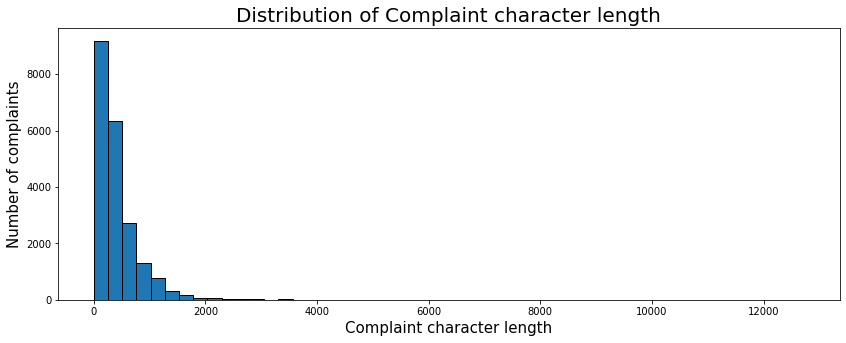

In [25]:
# Creating a histogram to view distribution of complaint character length
plt.figure(figsize=(14,5))
plt.hist(complaint_length, edgecolor='black', bins = 50)
plt.title('Distribution of Complaint character length', fontsize=20)
plt.ylabel('Number of complaints', fontsize=15)
plt.xlabel('Complaint character length', fontsize=15)
# sns.despine()
plt.show()

__OBSERVATION:__
- Complaint lengths vary from 0 to almost 4000
- There are around 9000 complaints with smaller character length

#### Find the top 40 words by frequency among all the articles after processing the text.

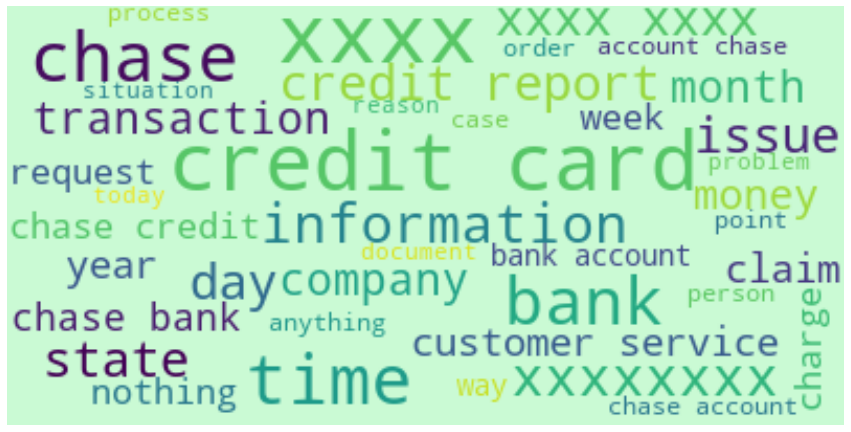

In [26]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)
word_cloud = WordCloud(
                          background_color='#cafad4',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

fig = plt.figure(figsize=(15,10))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')
plt.show()


__OBSERVATION:__
- credit card is the most frequent word followed by chase, bank and time
- personal information xxxxxxxx are shown among frequent words which should be removed
- the word cloud gives a rough estimate of different topics like credit cards, bank account, chase credit, credit report, customer service

In [27]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [28]:
# Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

# Creating a function for top n uni/bi/tri gram words
def get_topn_ggram_words(corpus, n=None, g=1):
    '''
    This function takes a input text and returns the top n words(g-uni/bi/trigrams) among the words in the corpus according 
    to their frequency of occurence.
    :param corpus: input text
    :param n: number of top words(g-grams) to find
    :return: list of tuples with two elements each: the word and its frequency
    '''
    vec = CountVectorizer(ngram_range=(g, g), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

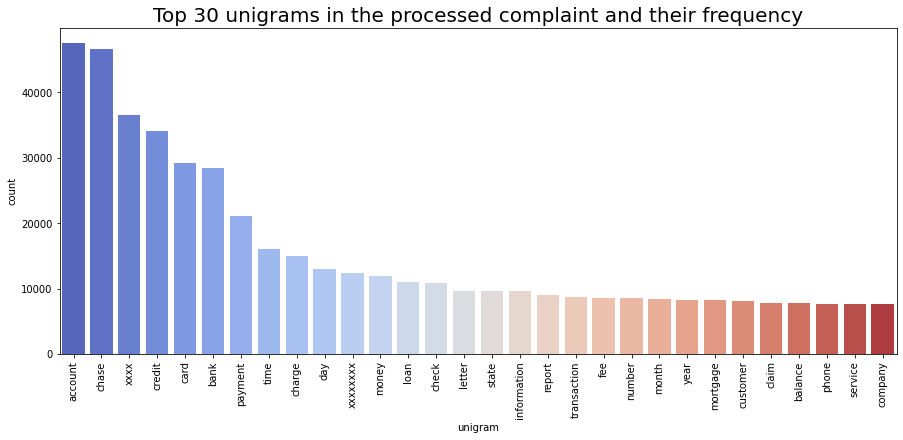

In [29]:
# Creating top 30 unigram dataframe
common_words = get_topn_ggram_words(df_clean['complaint_POS_removed'].values.astype('U'), 30, 1)
df_unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

# Plotting the top 30 unigrams
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=df_unigram, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the processed complaint and their frequency", fontsize=20)
plt.show()

In [30]:
#Print the top 10 words in the unigram frequency
df_unigram.head(10)

,unigram,count
0,account,47492
1,chase,46693
2,xxxx,36531
3,credit,34132
4,card,29279
5,bank,28408
6,payment,21167
7,time,16033
8,charge,14991
9,day,12966


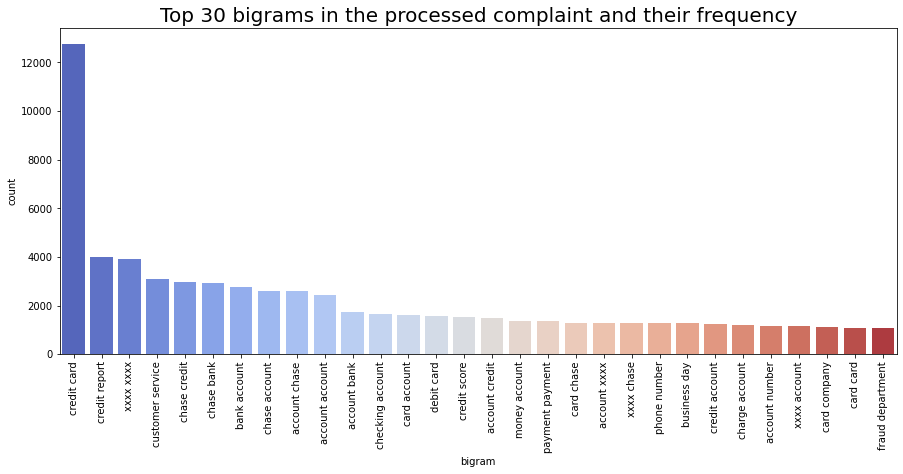

In [31]:
# Creating top 30 bigram dataframe
common_words = get_topn_ggram_words(df_clean['complaint_POS_removed'].values.astype('U'), 30, 2)
df_bigram = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

# Plotting the top 30 bigrams
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=df_bigram, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the processed complaint and their frequency", fontsize=20)
plt.show()

In [32]:
# Print the top 10 words in the bigram frequency
df_bigram.head(10)

,bigram,count
0,credit card,12779
1,credit report,4003
2,xxxx xxxx,3931
3,customer service,3079
4,chase credit,2967
5,chase bank,2944
6,bank account,2778
7,chase account,2619
8,account chase,2595
9,account account,2414


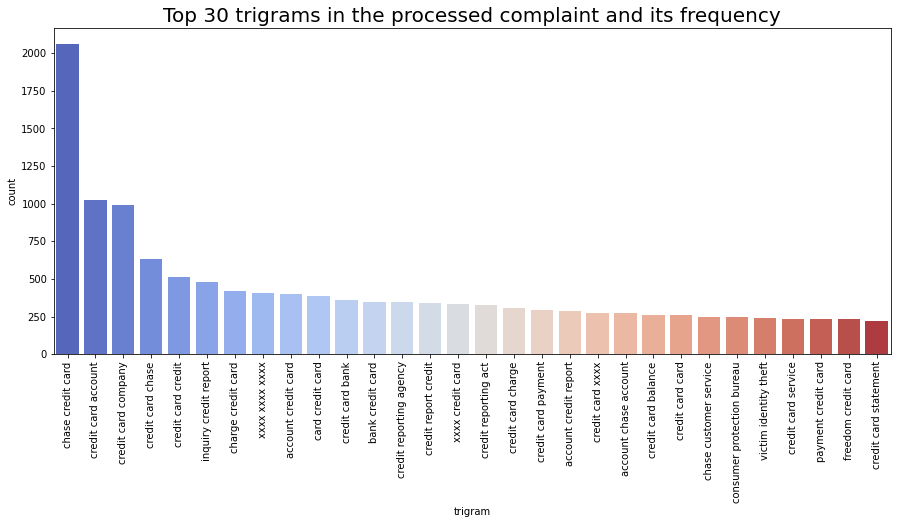

In [33]:
# Creating top 30 trigram dataframe
common_words = get_topn_ggram_words(df_clean['complaint_POS_removed'].values.astype('U'), 30, 3)
df_trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])

# Plotting the top 30 trigrams
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=df_trigram, palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the processed complaint and its frequency", fontsize=20)
plt.show()

In [34]:
# Print the top 10 words in the trigram frequency
df_trigram.head(10)

,trigram,count
0,chase credit card,2063
1,credit card account,1026
2,credit card company,990
3,credit card chase,634
4,credit card credit,514
5,inquiry credit report,480
6,charge credit card,422
7,xxxx xxxx xxxx,410
8,account credit card,401
9,card credit card,388


__OBSERVATION:__
- From unigrams, we can get broad categories as account, credit, chase, card, payment
- From bigrams, the major categories are again similar bank amount, credit card, chase account, credit report
- from trigram mostly the categories are related to credit card and credit report

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [42]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')
df_clean['Complaint_clean'].str.lower().str.replace('xx+','',regex=True)

In [43]:
#All masked texts has been removed
df_clean.head(2)

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,card agent upgrade date agent information order account change date consent recording agent


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [44]:
#Write your code here to initialise the TfidfVectorizer 

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [45]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [46]:
from sklearn.decomposition import NMF


## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [47]:
!pip install -U gensim==3.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [48]:
# Use Coherence model to find best number of topics
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from operator import itemgetter

# Use Gensim's NMF to get the best num of topics via coherence score
texts = df_clean['complaint_POS_removed']
dataset = [d.split() for d in texts]

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(dataset)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in dataset]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 10, 1))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    print(cm.get_coherence())
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

print(best_num_topics)

ModuleNotFoundError: ignored

In [49]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=5, random_state=40) #write your code here

In [50]:
# fitting the nmf model
nmf_model.fit(dtm)
len(tfidf.get_feature_names_out())

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



7257

In [51]:
# Print the Top15 words for each of the topics
for index,topic in enumerate(nmf_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['transfer', 'claim', 'checking', 'transaction', 'business', 'number', 'day', 'branch', 'deposit', 'chase', 'fund', 'money', 'check', 'bank', 'account']


THE TOP 15 WORDS FOR TOPIC #1
['balance', 'year', 'letter', 'application', 'debt', 'information', 'limit', 'company', 'score', 'account', 'chase', 'inquiry', 'report', 'card', 'credit']


THE TOP 15 WORDS FOR TOPIC #2
['mortgage', 'year', 'chase', 'account', 'credit', 'pay', 'date', 'auto', 'time', 'day', 'statement', 'fee', 'month', 'balance', 'payment']


THE TOP 15 WORDS FOR TOPIC #3
['company', 'refund', 'statement', 'time', 'service', 'claim', 'purchase', 'fraud', 'merchant', 'chase', 'dispute', 'transaction', 'fee', 'card', 'charge']


THE TOP 15 WORDS FOR TOPIC #4
['sale', 'foreclosure', 'house', 'bank', 'document', 'time', 'rate', 'letter', 'year', 'property', 'chase', 'modification', 'home', 'mortgage', 'loan']




__OBSERVATION:__
- Topic 0 contains words such as transfer, transaction, account, branch, deposit. Seems like realted to bank account services
- Topic 1 contains words such as balance, debt, limit, score, vredit. Seems like related to credit card/prepaid card
- Topic 2 contains mix of all varieties like mortgage, chase, year, time, auto, balance, payment. Seems like miscelleneous category
- Topic 3 contains refund, fraud, merchant, dispute, charge. Seems like related to fraud/theft
- Topic 4 contains foreclosure, house, bank, mortgage, loan. Clearly for Mortgage/loan

In [52]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

topic_assign = nmf_model.transform(dtm)
topic_assign[0].round(2)
topic_assign[0].argmax()
topic_assign.argmax(axis=1)

array([0, 1, 1, ..., 3, 2, 2])

In [53]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] =  topic_assign.argmax(axis=1) #write your code to assign topics to each rows.

In [54]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,card agent upgrade date agent information order account change date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is no

In [55]:
#Print the first 5 Complaint for each of the Topics
df_clean_top=df_clean.groupby('Topic').head(5)
df_clean_top.sort_values('Topic')

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen check number xxxx claim number is xxxx with chase,my grand son give I check for I deposit it into my chase account after fund clear my chase bank close my account never pay I my money they say they need to speek with my grand son check be clear money be take by my chase bank refuse to pay I my money my grand son call chase time they tell he I should call not he to verify the check owner he be out the country most the time date happen check number xxxx claim number be xxxx with chase,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date check number claim number chase,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date check number claim number chase,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday on thursday i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two business day stating tuesday xxxxxxxx would be the date that my funds would be available to withdraw from a bank teller only now chase is informing me that i will be mailed a check into the three business days to recover the funds that are owed to me and left in my account currently unfortunately this has put me in an additional financial bind do two fees from late rent late car payments etc i am not being a short or giving written notice that these things will actually occur so that i have peace of mind in fact chase has handled my situation grossly i even had a bank teller inform me that my account looks

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [56]:
#Create the dictionary of Topic names and Topics

Topic_categories = {0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"}

#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_categories)

In [57]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,Bank Account services
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,card agent upgrade date agent information order account change date consent recording agent,Credit card or prepaid card
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,Credit card or prepaid card
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chas

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [58]:
#Create the dictionary again of Topic names and Topics

Topic_categories = {"Bank Account services":0,
               "Credit card or prepaid card":1,
               "Others":2,
               "Theft/Dispute Reporting":3,
               "Mortgage/Loan":4}
               
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_categories)

In [59]:
df_clean.head()

,complaint_what_happened,lemmatized_complaint,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning my name be xxxx xxxx and I appreciate it if you could help I put a stop to chase bank cardmember service \n in I write to chase ask for debt verification and what they send I a statement which be not acceptable I be ask the bank to validate the debt instead I been receive mail every month from they attempt to collect a debt \n I have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for your help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,0
2,i upgraded my xxxx xxxx card in and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,I upgrade my xxxx xxxx card in and be tell by the agent who do the upgrade my anniversary date would not change it turn the agent be give I the wrong information in order to upgrade the account xxxx change my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx have the recording of the agent who be mislead I,card agent upgrade date agent information order account change date xxxxxxxx consent xxxx recording agent,card agent upgrade date agent information order account change date consent recording agent,1
10,chase card was reported on however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on however fraudulent application have be submit my identity without my consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card report application identity consent service credit identity applicant,card report application identity consent service credit identity applicant,1
11,on while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than after putting in the application on notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on this is no

In [60]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean[["Complaint_clean","Topic"]]

In [61]:
# checking training_data
training_data.head()

,Complaint_clean,Topic
1,morning name stop bank cardmember service ask debt verification statement bank debt mail month debt right information consumer chase account thank advance help,0
2,card agent upgrade date agent information order account change date consent recording agent,1
10,card report application identity consent service credit identity applicant,1
11,try book ticket offer ticket card information offer minute screen decision bank chase bank notification screen chase representative application state information offer credit offer account statement use ticket account application representative oblige put application explicit request application chase chase fact credit account name report credit report chase information credit report application error,1
14,son chase account fund bank account pay money son check money bank refuse money son call chase time check owner country time date check number claim number chase,0


In [62]:
training_data.shape

(21072, 2)

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [63]:
import pickle
#Write your code to get the Vector count
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(training_data['Complaint_clean'])
pickle.dump(count_vect.vocabulary_, open("count_vector.pkl","wb"))


In [64]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
pickle.dump(tfidf_transformer, open("tfidf.pkl","wb"))


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [65]:
# Libraries for evaluating models
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report

# Perform Train-Test and split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.25, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (15804, 16326)
y_train shape: (15804,)
X_test shape: (5268, 16326)
y_test shape: (5268,)


In [66]:
# Create a function to evaluate models (that prints the classification report of a classifier and plots the confusion martrix)
def model_evaluation(y_test, y_pred, model_name):
    
    # printing classification report of classifier
    print(f"{model_name} CLASSIFICATION REPORT \n")
    print(classification_report(y_test, y_pred, target_names=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"]))
    
    # plotting confusion matrix of the classifier
    plt.figure(figsize=(10,6))
    plt.title(f"{model_name} CONFUSION MATRIX \n")
    matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(matrix, annot=True, cbar=None, cmap="Blues", fmt='d', xticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"], yticklabels=["Bank Account services", "Credit card or prepaid card", "Others", "Theft/Dispute Reporting",
"Mortgage/Loan"])
    plt.show()
    
    return

In [67]:
# Write your code here to build any 3 models and evaluate them using the required metrics
# Libraries for below machine learning models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

**Model #1: Logistic Regression**

In [68]:
#Create the Logistic Regression model and fit on default hyperparameters
model_name = 'LOGISTIC REGRESSION'
classification_lr = LogisticRegression(solver='liblinear')
%time 
classification_lr.fit(X_train, y_train)
y_pred_lr = classification_lr.predict(X_test)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11 µs


In [69]:
# Calculating F1 Score using the weighted average method
lr_f1_score = f1_score(y_test, y_pred_lr, average="weighted")
lr_f1_score

0.9566408165240516

In [70]:
# Running Logistic Regression model on tuned hyperparameters
classification_lr_tuned = LogisticRegression(C=1, 
                                  penalty='l1', 
                                  solver='saga')
%time 
classification_lr_tuned.fit(X_train, y_train)
y_pred_lr_tuned = classification_lr_tuned.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [71]:
#Now, Calculating F1 Score for LR tuned model using weighted average method
lr_f1_score_tuned = f1_score(y_test, y_pred_lr_tuned, average="weighted")
lr_f1_score_tuned

0.971714084579907

LOGISTIC REGRESSION CLASSIFICATION REPORT 

                             precision    recall  f1-score   support

      Bank Account services       0.98      0.98      0.98      1324
Credit card or prepaid card       0.97      0.98      0.98      1282
                     Others       0.96      0.97      0.97       555
    Theft/Dispute Reporting       0.98      0.96      0.97      1191
              Mortgage/Loan       0.96      0.96      0.96       916

                   accuracy                           0.97      5268
                  macro avg       0.97      0.97      0.97      5268
               weighted avg       0.97      0.97      0.97      5268



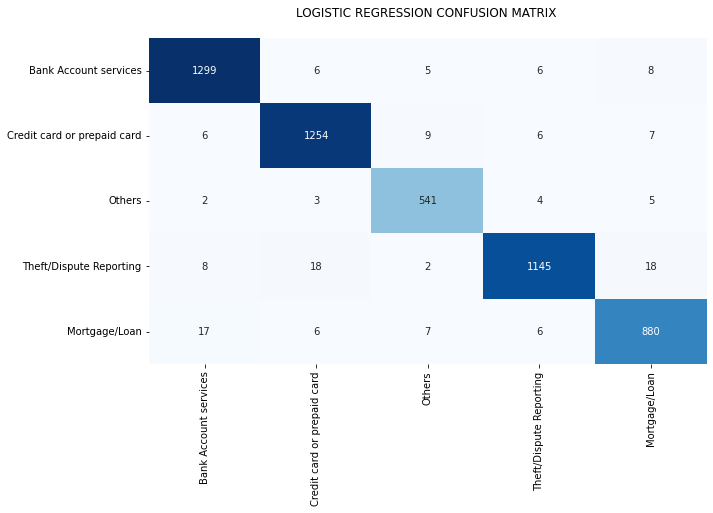

In [72]:
# Evaluating the tuned Logistic Regression classifier model
model_evaluation(y_test, y_pred_lr_tuned, model_name)

In [73]:
# Create a summary dataframe to store and show F1 Scores of all the models
summary = pd.DataFrame([{'Model': 'Logistic Regression','F1 Score (untuned)': round(lr_f1_score, 2), 'F1 Score (tuned)': round(lr_f1_score_tuned, 2)}])
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.96,0.97


**Observation :**
- We can observe that the F1 score for tuned Logistic Regression model is pretty high i.e 0.97
- That means Logistic Regression model performs well on all topics.


**Model #2: Decision Tree**

In [74]:
#Create the DECISION TREE model and fit on default hyperparameters
model_name = 'DECISION TREE'
classification_dt = DecisionTreeClassifier()
%time 
classification_dt.fit(X_train, y_train)
y_pred_dt = classification_dt.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


In [75]:
# Calculating F1 Score using the weighted average method
dt_f1_score = f1_score(y_test, y_pred_dt, average="weighted")
dt_f1_score

0.8327196876068533

In [76]:
# Running Decision Tree model on tuned hyperparameters
classification_dt_tuned = DecisionTreeClassifier(criterion='gini', 
                                      max_depth=30, 
                                      min_samples_leaf=15, 
                                      max_features=None)
%time 
classification_dt_tuned.fit(X_train, y_train)
y_pred_dt_tuned = classification_dt_tuned.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.06 µs


In [77]:
#Now, Calculating F1 Score for DT tuned model using weighted average method
dt_f1_score_tuned = f1_score(y_test, y_pred_dt_tuned, average="weighted")
dt_f1_score_tuned

0.8371550875057323

DECISION TREE CLASSIFICATION REPORT 

                             precision    recall  f1-score   support

      Bank Account services       0.83      0.87      0.85      1324
Credit card or prepaid card       0.83      0.87      0.85      1282
                     Others       0.84      0.83      0.83       555
    Theft/Dispute Reporting       0.84      0.78      0.81      1191
              Mortgage/Loan       0.86      0.84      0.85       916

                   accuracy                           0.84      5268
                  macro avg       0.84      0.84      0.84      5268
               weighted avg       0.84      0.84      0.84      5268



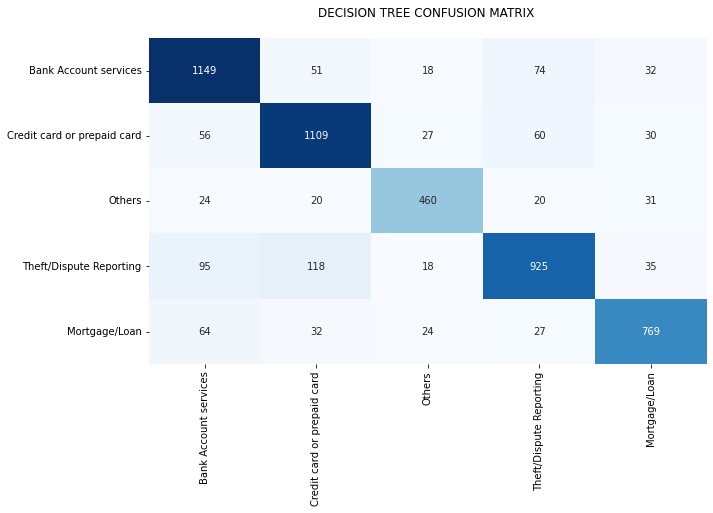

In [78]:
# Evaluating the tuned Decision Tree classifier
model_evaluation(y_test, y_pred_dt_tuned, model_name)

In [79]:
# Updating the summary table for Decision Tree classifier
summary.loc[len(summary.index)] = ['Decision Tree', round(dt_f1_score, 2), round(dt_f1_score_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.96,0.97
1,Decision Tree,0.83,0.84


**Observation :**
- We can observe that the F1 score for tuned Decision Tree model is pretty good i.e 0.84
- Also, as we can see Decision Tree model is able able to perform well on all topics (more than 0.80 on all the topics)


**Model #3: Random Forest**

In [80]:
#Create the RANDOM FOREST model and fit on default hyperparameters
model_name = 'RANDOM FOREST'
classification_rf = RandomForestClassifier()
%time 
classification_rf.fit(X_train, y_train)
y_pred_rf = classification_rf.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


In [81]:
# Calculating F1 Score using the weighted average method
rf_f1_score = f1_score(y_test, y_pred_rf, average="weighted")
rf_f1_score

0.8537810985281841

In [82]:
# Running RANDOM FOREST model on tuned hyperparameters
classification_rf_tuned = RandomForestClassifier(n_estimators=100, 
                                      min_samples_split=5, 
                                      min_samples_leaf=5, 
                                      max_features=None, 
                                      max_depth=30, 
                                      criterion='gini'
)
%time 
classification_rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = classification_rf_tuned.predict(X_test)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.82 µs


In [83]:
#Now, Calculating F1 Score for RF tuned model using weighted average method
rf_f1_score_tuned = f1_score(y_test, y_pred_rf_tuned, average="weighted")
rf_f1_score_tuned

0.8732663173694567

RANDOM FOREST CLASSIFICATION REPORT 

                             precision    recall  f1-score   support

      Bank Account services       0.87      0.89      0.88      1324
Credit card or prepaid card       0.88      0.89      0.89      1282
                     Others       0.87      0.85      0.86       555
    Theft/Dispute Reporting       0.86      0.84      0.85      1191
              Mortgage/Loan       0.88      0.89      0.88       916

                   accuracy                           0.87      5268
                  macro avg       0.87      0.87      0.87      5268
               weighted avg       0.87      0.87      0.87      5268



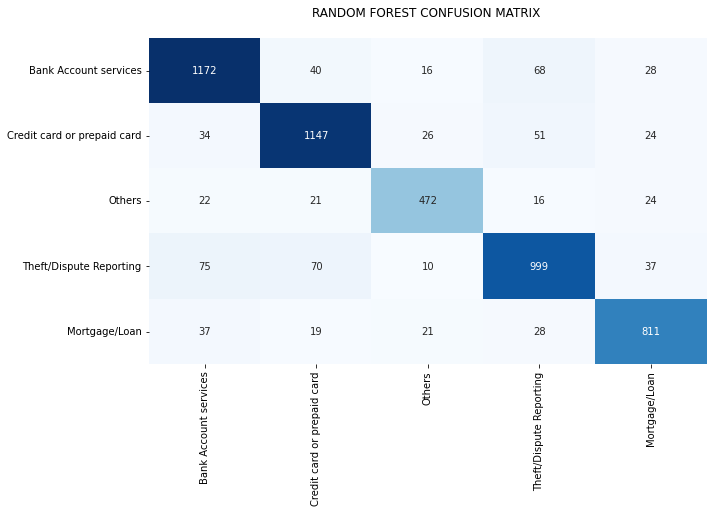

In [84]:
# Evaluating the tuned Random Forest classifier
model_evaluation(y_test, y_pred_rf_tuned, model_name)

In [85]:
# Updating the summary table for Random Forest classifier
summary.loc[len(summary.index)] = ['Random Forest', round(rf_f1_score, 2), round(rf_f1_score_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.96,0.97
1,Decision Tree,0.83,0.84
2,Random Forest,0.85,0.87


**Observation :**
- We can observe that the F1 score for tuned Random Forest model is pretty good i.e 0.87
- Also, as we can see that Random Forest model performs good on all topics.

**`Model #4: Naive Bayes`** (Optional)

In [86]:
#Create the Multinomial Naive Bayes model and fit on default hyperparameters
model_name = 'NAIVE BAYES'
classification_nb = MultinomialNB()
%time 
classification_nb.fit(X_train, y_train)
y_pred_nb = classification_nb.predict(X_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [87]:
# Calculating F1 Score using the weighted average method
nb_f1_score = f1_score(y_test, y_pred_nb, average="weighted")
nb_f1_score

0.7274175812977641

In [88]:
# Running Multinomial Naive Bayes model on tuned hyperparameters
classification_nb_tuned = MultinomialNB(alpha=0.1, fit_prior=False)
%time 
classification_nb_tuned.fit(X_train, y_train)
y_pred_nb_tuned = classification_nb_tuned.predict(X_test)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.11 µs


In [89]:
#Now, Calculating F1 Score for NB tuned model using weighted average method
nb_f1_score_tuned = f1_score(y_test, y_pred_nb_tuned, average="weighted")
nb_f1_score_tuned

0.7924928210620593

NAIVE BAYES CLASSIFICATION REPORT 

                             precision    recall  f1-score   support

      Bank Account services       0.82      0.83      0.83      1324
Credit card or prepaid card       0.81      0.76      0.79      1282
                     Others       0.62      0.69      0.65       555
    Theft/Dispute Reporting       0.78      0.78      0.78      1191
              Mortgage/Loan       0.85      0.86      0.85       916

                   accuracy                           0.79      5268
                  macro avg       0.78      0.78      0.78      5268
               weighted avg       0.79      0.79      0.79      5268



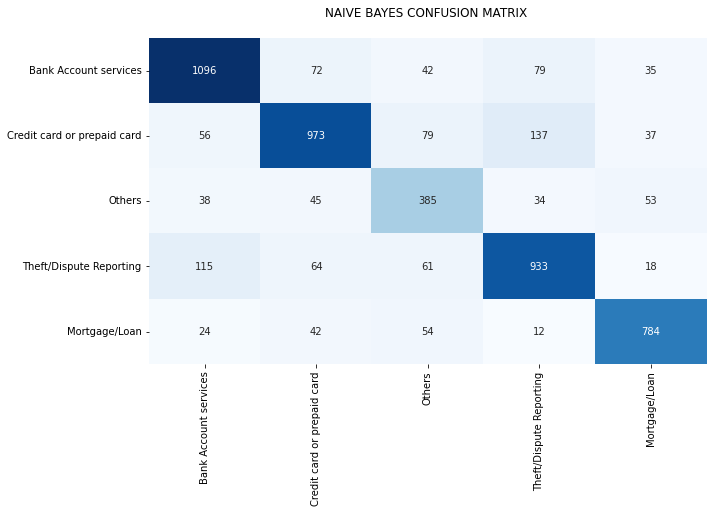

In [90]:
 # Evaluating the tuned Random Forest classifier model
model_evaluation(y_test, y_pred_nb_tuned, model_name)

In [91]:
# Updating the summary table for Naive Bayes classifier
summary.loc[len(summary.index)] = ['Naive Bayes', round(nb_f1_score, 2), round(nb_f1_score_tuned, 2)]
summary

,Model,F1 Score (untuned),F1 Score (tuned)
0,Logistic Regression,0.96,0.97
1,Decision Tree,0.83,0.84
2,Random Forest,0.85,0.87
3,Naive Bayes,0.73,0.79


**Observation :**
- We can observe that the F1 score for tuned Naive Bayes model is pretty decent i.e 0.79
- However, as we can see Naive Bayes model is not able to perform well on classifying Others and Theft/Dispute Reporting topics.